In [38]:
import numpy as np
import astropy
from astropy.io import fits
from matplotlib import pyplot
import pandas as pd
import os


from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

import auxil_ML as aux
import plotting as my_plot

In [362]:
if 1:
    import importlib
    importlib.reload(aux);


In [125]:
classifiers = [
    RandomForestClassifier(max_depth=5, n_estimators=50, max_features="sqrt"),
    AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), 
                       n_estimators=50),
    MLPClassifier(alpha=1, max_iter=1000, hidden_layer_sizes=(10,), activation='tanh'),
    LogisticRegression(C=1e5)
]
algs = ["RF", "BDT", "NN", "LR"]
pars_dict = {'RF':range(1,21,2), 'BDT':range(1,21,2), 'NN':range(1,20, 2), "LR":range(50,401,50)}
pars_names = {'RF':'max depth', 'BDT':'max depth', 'NN':'number of neurons', 
              'LR':'iterations'}

def get_classifier(alg, par):
    if alg == 'RF':
        return RandomForestClassifier(max_depth=par, n_estimators=50, 
                                      max_features="sqrt")
    elif alg == 'BDT':
        return AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=par), 
                                  n_estimators=50)
    elif alg == 'NN':
        return MLPClassifier(alpha=1, max_iter=1000, hidden_layer_sizes=(par,), 
                             activation='tanh')
    elif alg == 'LR':
        return LogisticRegression(C=1e2, max_iter=par)

In [313]:
cat = '3FGL'
nclasses = 2

cat_fn = 'data/%s_prob_catalog_LE_index.csv' % (cat)
cat_fn_out = 'data/%s_prob_catalog_%iclass.csv' % (cat, nclasses)
cat_df = pd.read_csv(cat_fn, index_col=0)
nps = len(cat_df)

cat_df3 = pd.DataFrame(index=cat_df.index)
cat_df3['n'] = np.zeros(nps)

In [314]:
cat_df.columns

Index(['Ln_Flux_Density', 'Ln_Unc_Energy_Flux100', 'Spectral_Index',
       'Ln_Signif_Curve', 'Ln_Variability_Index', 'HR12', 'HR23', 'HR34',
       'HR45', 'GLAT', 'Category_3FGL', 'CLASS_3FGL', 'Pivot_Energy',
       'Spectrum_Type', 'ASSOC1', 'GLON', 'Source_Name', 'AGN_BDT_O',
       'AGN_BDT_STD_O', 'PSR_BDT_O', 'PSR_BDT_STD_O', 'AGN_NN_O',
       'AGN_NN_STD_O', 'PSR_NN_O', 'PSR_NN_STD_O', 'AGN_RF_O', 'AGN_RF_STD_O',
       'PSR_RF_O', 'PSR_RF_STD_O', 'AGN_LR_O', 'AGN_LR_STD_O', 'PSR_LR_O',
       'PSR_LR_STD_O', 'AGN_BDT', 'AGN_BDT_STD', 'PSR_BDT', 'PSR_BDT_STD',
       'AGN_NN', 'AGN_NN_STD', 'PSR_NN', 'PSR_NN_STD', 'AGN_RF', 'AGN_RF_STD',
       'PSR_RF', 'PSR_RF_STD', 'AGN_LR', 'AGN_LR_STD', 'PSR_LR', 'PSR_LR_STD',
       'Flags', 'Category_Prob', 'LE_Index'],
      dtype='object')

In [315]:
features = ['Ln_Flux_Density', 'Ln_Unc_Energy_Flux100', 'LE_Index',
       'Ln_Signif_Curve', 'Ln_Variability_Index', 'HR12', 'HR23', 'HR34',
       'HR45', 'GLAT',]
classes = ['AGN', 'PSR', 'OTHER', 'UNAS']
clf_classes = classes[:nclasses]
unas_classes = classes[nclasses:]
cat_classes = ['AGN', 'PSR', 'OTHER', 'MIXED']

In [316]:
masks = {cls:(cat_df['Category_%s' % cat] == cls) for cls in classes}

In [317]:
clf_mask = False
rest_mask = False
for cls in clf_classes:
    clf_mask |= masks[cls]
for cls in unas_classes:
    rest_mask |= masks[cls]
X = cat_df[features][clf_mask]
y = cat_df['Category_%s' % cat][clf_mask]
X_rest = cat_df[features][rest_mask]
print(sum(clf_mask))

1905


In [318]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)


In [319]:
# scan complexity parameter
scores = {}
nav = 10
for alg in algs:
    print(alg)
    scores[alg] = np.zeros_like(pars_dict[alg], dtype=float)
    for i, par in enumerate(pars_dict[alg]):
        print(par)
        clf = get_classifier(alg, par)
        for j in range(nav):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                                random_state=j)
            clf.fit(X_train, y_train)
            scores[alg][i] += clf.score(X_test, y_test) / nav


RF
1
3
5
7
9
11
13
15
17
19
BDT
1
3
5
7
9
11
13
15
17
19
NN
1
3
5
7
9
11
13
15
17
19
LR
50


/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

100


/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

150


/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

200


/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

250


/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

300


/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

350


/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

400


/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

In [320]:
scores

{'RF': array([0.91363636, 0.96468531, 0.9715035 , 0.97482517, 0.9743007 ,
        0.97447552, 0.97447552, 0.97395105, 0.9729021 , 0.97447552]),
 'BDT': array([0.97185315, 0.97412587, 0.9756993 , 0.9743007 , 0.96730769,
        0.96573427, 0.96276224, 0.96188811, 0.96031469, 0.96048951]),
 'NN': array([0.91381119, 0.95541958, 0.97377622, 0.96625874, 0.9729021 ,
        0.9736014 , 0.97465035, 0.97412587, 0.97395105, 0.975     ]),
 'LR': array([0.9715035 , 0.975     , 0.9743007 , 0.97412587, 0.97412587,
        0.97412587, 0.97465035, 0.97482517])}

RF 7 0.9748251748251748
BDT 5 0.9756993006993009
NN 19 0.975
LR 100 0.9750000000000001


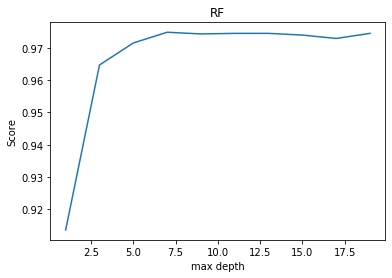

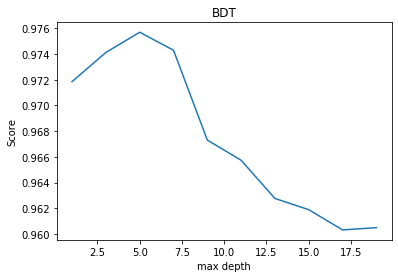

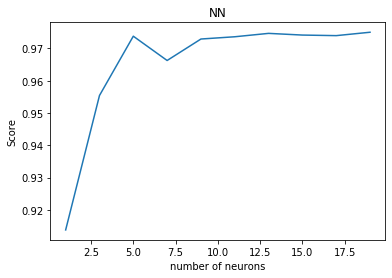

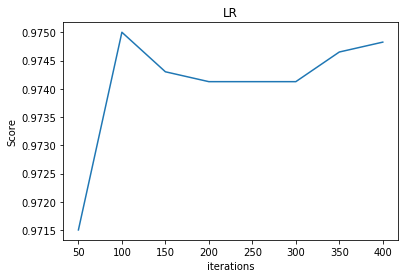

In [321]:
best_pars = {}
for alg in algs:
    ind = np.argmax(scores[alg])
    best_pars[alg] = pars_dict[alg][ind]
    print(alg, best_pars[alg], scores[alg][ind])
    pyplot.figure()
    pyplot.plot(pars_dict[alg], scores[alg])
    pyplot.xlabel(pars_names[alg])
    pyplot.ylabel('Score')
    pyplot.title(alg)

In [322]:
for alg in algs:
    par = best_pars[alg]
    print(alg, par)
    columns = ['%s_%s' % (cls, alg) for cls in clf_classes]
    for clm in columns: 
        cat_df3[clm] = 0.
    clf = get_classifier(alg, par)
    cat_df3['n'] = 0.
    j = 0
    while np.min(cat_df3['n']) < 3:
        print(j)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                            random_state=j)
        clf.fit(X_train, y_train)
        columns = ['%s_%s' % (cls, alg) for cls in clf.classes_]
        pred_test = clf.predict_proba(X_test).T
        pred_rest = clf.predict_proba(X_rest).T
        for i, clm in enumerate(columns):
            cat_df3[clm][X_test.index] += pred_test[i]
            cat_df3[clm][X_rest.index] += pred_rest[i]
        cat_df3['n'][X_test.index] += 1
        cat_df3['n'][X_rest.index] += 1
        j += 1
        
    for clm in columns: 
        cat_df3[clm] /= cat_df3['n']
    

RF 7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
BDT 5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
NN 19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
LR 100
0
1
2


/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

3
4
5


/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

6
7
8


/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

9
10
11


/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

12
13


/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

14
15


/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

16
17


/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

18
19


/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

20
21
22


/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

23
24
25


/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

26
27
28


/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

29
30
31


/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

32
33
34


/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

35
36
37


/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

In [328]:
cat_df3

,AGN_RF,PSR_RF,n,AGN_BDT,PSR_BDT,AGN_NN,PSR_NN,AGN_LR,PSR_LR,Category_Prob
Source_Name_3FGL,,,,,,,,,,
3FGL J0001.2-0748,0.908777,0.091223,10.0,0.999985,1.482884e-05,0.981580,0.018420,0.965069,3.493136e-02,AGN
3FGL J0002.2-4152,0.999585,0.000415,7.0,1.000000,1.211964e-10,0.998605,0.001395,1.000000,1.312106e-07,AGN
3FGL J0003.2-5246,0.997345,0.002655,15.0,1.000000,1.372182e-10,0.996796,0.003204,0.999614,3.862531e-04,AGN
3FGL J0003.8-1151,0.987188,0.012812,17.0,1.000000,8.054497e-10,0.992800,0.007200,0.994858,5.142188e-03,AGN
3FGL J0004.7-4740,0.944090,0.055910,11.0,1.000000,1.049168e-07,0.993304,0.006696,0.994933,5.066632e-03,AGN
...,...,...,...,...,...,...,...,...,...,...
3FGL J2221.7+6318,0.558502,0.441498,38.0,0.640298,3.597022e-01,0.066096,0.933904,0.074229,9.257706e-01,MIXED
3FGL J2233.1+6542,0.625487,0.374513,38.0,0.282494,7.175064e-01,0.156042,0.843958,0.123609,8.763908e-01,MIXED
3FGL J2237.9+6320,0.536594,0.463406,38.0,0.486294,5.137062e-01,0.155050,0.844950,0.317220,6.827798e-01,MIXED


In [363]:
cat_df3['Category_Prob'] = aux.get_prob_class(cat_df3, algs, clf_classes)['Category_Prob']

RF
BDT
NN
LR


In [361]:
for cls in cat_classes:
    print(cls, np.sum(cat_df3['Category_Prob'] == cls))

AGN 2513
PSR 287
OTHER 0
MIXED 221


In [347]:
cat_df3['Category_3FGL'] = cat_df['Category_3FGL']
cat_df3.to_csv(cat_fn_out, index=True, float_format='%.9g')

In [335]:
#dir(classifiers[0].predict)
print(classifiers[0].predict.__doc__)


        Predict class for X.

        The predicted class of an input sample is a vote by the trees in
        the forest, weighted by their probability estimates. That is,
        the predicted class is the one with highest mean probability
        estimate across the trees.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The input samples. Internally, its dtype will be converted to
            ``dtype=np.float32``. If a sparse matrix is provided, it will be
            converted into a sparse ``csr_matrix``.

        Returns
        -------
        y : ndarray of shape (n_samples,) or (n_samples, n_outputs)
            The predicted classes.
        


In [337]:
# functions
def precision(true_labels, pred_labels, cls):
    true_mask = (true_labels == cls)
    pred_mask = (pred_labels == cls)
    return np.sum(true_mask * pred_mask) / np.sum(pred_mask)

def recall(true_labels, pred_labels, cls):
    true_mask = (true_labels == cls)
    pred_mask = (pred_labels == cls)
    return np.sum(true_mask * pred_mask) / np.sum(true_mask)


for cls in clf_classes:
    true_labels = cat_df['Category_%s' % cat][~masks['UNAS']]
    pred_labels = cat_df3['Category_Prob'][~masks['UNAS']]
    prec = precision(true_labels, pred_labels, cls)
    rec = recall(true_labels, pred_labels, cls)
    print(cls, prec, rec)

AGN 0.9593314763231198 0.9902242668200115
PSR 0.75 0.7048192771084337


/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [339]:
for cls in cat_classes:
    print(cls, sum(true_labels == cls), sum(pred_labels == cls))

AGN 1739 1795
PSR 166 156
OTHER 108 0
MIXED 0 62


In [342]:
# 3 class
cat_fn = 'data/%s_prob_catalog_3class.csv' % (cat)
cat_df_check = pd.read_csv(cat_fn, index_col=0)
cat_df_check['Category_%s' % cat] = cat_df['Category_%s' % cat]
masks_check = {cls:(cat_df_check['Category_%s' % cat] == cls) for cls in classes}

In [349]:
true_labels = cat_df_check['Category_%s' % cat][~masks_check['UNAS']]
pred_labels = cat_df_check['Category_Prob'][~masks_check['UNAS']]
for cls in classes[:3]:
    prec = precision(true_labels, pred_labels, cls)
    rec = recall(true_labels, pred_labels, cls)
    print(cls, prec, rec)

AGN 0.9749144811858609 0.983323749281196
PSR 0.8376068376068376 0.5903614457831325
OTHER 0.6470588235294118 0.10185185185185185


In [346]:
for cls in cat_classes:
    print(cls, sum(true_labels == cls), sum(pred_labels == cls))

AGN 1739 1754
PSR 166 117
OTHER 108 17
MIXED 0 125


In [348]:
cat_df_check['Category_3FGL'] = cat_df['Category_3FGL']
cat_df_check.to_csv(cat_fn, index=True, float_format='%.9g')

In [357]:
all_names.remove('s')

ValueError: list.remove(x): x not in list